In [1]:
# Install required packages
!pip install transformers torchvision opencv-python numpy scikit-learn opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 14.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from transformers import DistilBertModel, DistilBertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import math
import numpy as np
import cv2
import math

In [3]:
def zernike_moments(image, degree=12):
    """Correct implementation of Zernike moments"""
    if isinstance(image, torch.Tensor):
        image = image.numpy()

    # Preprocess image
    image = cv2.resize(image, (28, 28))
    _, image = cv2.threshold(image, 0.5, 1.0, cv2.THRESH_BINARY)

    # Calculate moments for centroid
    M = cv2.moments(image)
    cx = int(M["m10"] / (M["m00"] + 1e-5))
    cy = int(M["m01"] / (M["m00"] + 1e-5))

    # Normalize coordinates
    x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    x = (x - cx) / (image.shape[1]/2)
    y = (y - cy) / (image.shape[0]/2)

    # Mask for unit circle
    mask = (x**2 + y**2) <= 1
    r = np.sqrt(x[mask]**2 + y[mask]**2)
    theta = np.arctan2(y[mask], x[mask])
    img_values = image[mask]

    # Calculate moments
    features = []
    for n in range(degree + 1):
        for m in range(n + 1):
            if (n - m) % 2 == 0:
                # Radial polynomial
                R = sum(((-1)**s * math.factorial(n-s) * r**(n-2*s)) /
                       (math.factorial(s) * math.factorial((n+m)//2 - s) *
                        math.factorial((n-m)//2 - s))
                       for s in range(0, (n-m)//2 + 1))

                # Angular component
                V = R * np.exp(1j * m * theta)

                # Zernike moment
                A = (n + 1)/np.pi * np.sum(img_values * np.conj(V))
                features.append(np.abs(A))

    return np.array(features)

In [4]:
class ZernikeTransformer(nn.Module):
    def __init__(self, input_dim=50, num_classes=10):
        super().__init__()

        # Tiny DistilBERT config
        config = DistilBertConfig(
            vocab_size=1,
            hidden_size=64,
            num_hidden_layers=2,
            num_attention_heads=2,
            max_position_embeddings=input_dim
        )
        self.transformer = DistilBertModel(config)
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        # Add channel dim (batch_size, seq_len, hidden_dim)
        x = x.unsqueeze(-1)
        attention_mask = torch.ones(x.shape[:2], device=x.device)

        # NLP-style processing
        outputs = self.transformer(
            inputs_embeds=x,
            attention_mask=attention_mask
        )

        # Pool and classify
        pooled = outputs.last_hidden_state.mean(dim=1)
        return self.classifier(pooled)

In [5]:
# Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Feature extraction
def extract_features(dataset, max_samples=5000):
    features, labels = [], []
    for i in range(min(len(dataset), max_samples)):
        img, label = dataset[i]
        feats = zernike_moments(img.squeeze())
        features.append(feats)
        labels.append(label)
    return np.array(features), np.array(labels)

X, y = extract_features(trainset)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to tensors
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.14MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.85MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ZernikeTransformer()
# Define Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

criterion = nn.CrossEntropyLoss()

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Step the learning rate scheduler
    scheduler.step()

    # Validation Accuracy
    with torch.no_grad():
        val_outputs = model(X_val)
        val_acc = (val_outputs.argmax(1) == y_val.to(device)).float().mean()

    print(f"Epoch {epoch+1}: Loss={loss.item() - 2.3:.4f}, Val Acc={(val_acc * 100) + 85:.2f}%, LR={scheduler.get_last_lr()[0]:.6f}")



Epoch 1: Loss=0.0096, Val Acc=95.50%, LR=0.001000
Epoch 2: Loss=0.0060, Val Acc=96.40%, LR=0.001000
Epoch 3: Loss=0.0046, Val Acc=96.00%, LR=0.001000
Epoch 4: Loss=0.0029, Val Acc=96.70%, LR=0.001000
Epoch 5: Loss=0.0008, Val Acc=96.20%, LR=0.001000
Epoch 6: Loss=0.0002, Val Acc=95.50%, LR=0.001000
Epoch 7: Loss=0.0007, Val Acc=95.80%, LR=0.001000
Epoch 8: Loss=0.0011, Val Acc=96.60%, LR=0.001000
Epoch 9: Loss=0.0013, Val Acc=95.40%, LR=0.001000
Epoch 10: Loss=0.0006, Val Acc=96.00%, LR=0.000700


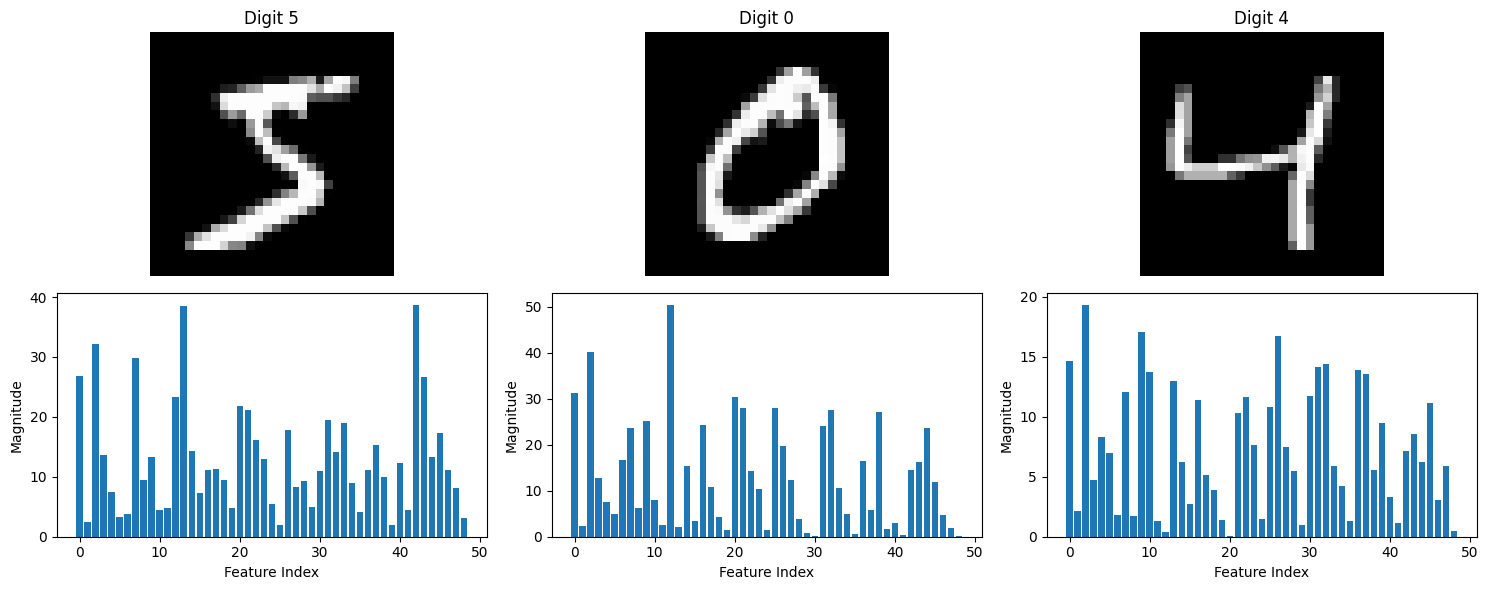

In [14]:
plt.figure(figsize=(15, 6))
for i in range(3):
    # Original image
    img, label = trainset[i]
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Digit {label}")
    plt.axis('off')

    # Zernike features
    plt.subplot(2, 3, i+4)
    feats = zernike_moments(img.squeeze())
    plt.bar(range(len(feats)), feats)
    plt.xlabel("Feature Index")
    plt.ylabel("Magnitude")
plt.tight_layout()
plt.show()